In [ ]:
#from google.colab import files
#files.upload()

In [ ]:
! ls

imgrepr-0.0.1-cp36-cp36m-linux_x86_64.whl  sample_data


In [ ]:
! pip uninstall imgrepr -y
! pip install imgrepr-0.0.1-cp36-cp36m-linux_x86_64.whl

Uninstalling imgrepr-0.0.1:
  Successfully uninstalled imgrepr-0.0.1
Processing ./imgrepr-0.0.1-cp36-cp36m-linux_x86_64.whl


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy
import sklearn
import platform
import matplotlib
import pickle
import torch
import torchvision
import umap
import PIL

print('python version:      {}'.format(platform.python_version()))
print('sklearn version:     {}'.format(sklearn.__version__))
print('umap version:        {}'.format(umap.__version__))
print('numpy version:       {}'.format(numpy.__version__))
print('matplotlib version:  {}'.format(matplotlib.__version__))
print('pickle version:      {}'.format(pickle.format_version))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('PIL version:         {}'.format(PIL.__version__))

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min, pairwise_distances
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
from torchvision import transforms
from imgrepr.image_patch import ImagePatchExtractor
from imgrepr.image_keypoint import ImageKeyPoint
from collections import Counter

random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

python version:      3.6.9
sklearn version:     0.22.2.post1
umap version:        0.4.6
numpy version:       1.18.5
matplotlib version:  3.2.2
pickle version:      4.0
torch version:       1.6.0+cu101
torchvision version: 0.7.0+cu101
PIL version:         7.0.0.post3


Mount GDrive:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
base_url = '/content/gdrive/My Drive/neuralnet-patchinit/cifar10_kmeans/'

# Load Data

Define data transform functions:

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

Define training set:

In [ ]:
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

Extracting ./data/cifar-10-python.tar.gz to ./data


Create train data loader:

In [ ]:
batch_size = 15500

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

# Create Patches

In [ ]:
def get_patches_from_batch(batch):
    patches = []
    for sample in batch:
        sample_patches = get_patches(sample)

        if sample_patches.shape[0] != 0:
            patches.append(sample_patches)

    return np.vstack(patches)


def get_patches(sample):
    image_rgb = np.moveaxis(sample, 0, -1)

    if np.max(image_rgb) != 0:
        image_rgb = (image_rgb * 255) / np.max(image_rgb)

    image_rgb = image_rgb.astype('uint8')
    
    patch_extractor = ImagePatchExtractor(7)
    patches = patch_extractor.get_keypoint_patches(image_rgb, "SIFT", 9, 5)

    patches = list(map(lambda p: np.moveaxis(p, 2, 0), patches))
    patches = list(map(lambda p: p.flatten(), patches))
    patches = list(map(lambda p: (p / 255.0).astype(np.double), patches))

    if not patches:
      return np.array([])

    return np.vstack(patches)


def show_sample(data):
    print("tensor shape: " + str(data.shape))
    print("min:          " + str(np.amin(data)))
    print("max:          " + str(np.amax(data)))
    
    fig = plt.figure()
    patch = np.moveaxis(data, 0, -1)
    plt.imshow(patch, cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])


def show_patches(patches):
    print("tensor shape: " + str(patches.shape))
    
    fig = plt.figure(figsize=(8,8))
    for i in range(patches.shape[0]):
        plt.subplot(3,3,i+1)
        plt.tight_layout()
        patch = np.moveaxis(patches[i], 0, -1)
        plt.imshow(patch, cmap='gray', interpolation='none')
        plt.xticks([])
        plt.yticks([])

Extract patches from samples:

In [ ]:
patch_data = []
sample_patch_data = None
test_sample = None

for batch_idx, (batch_data, batch_target) in enumerate(trainloader):
    batch_np = batch_data.detach().numpy()

    batch_patches = get_patches_from_batch(batch_np)
    patch_data.append(batch_patches)

    if batch_idx == 0:
        sample_patch_data = batch_patches
        test_sample = batch_np[0]


patch_data = np.vstack(patch_data)

print("total patches:  {}".format(patch_data.shape))
print("sample patches: {}".format(sample_patch_data.shape))

total patches:  (165450, 675)
sample patches: (51334, 675)


Show patches of first sample:

tensor shape: (9, 3, 15, 15)


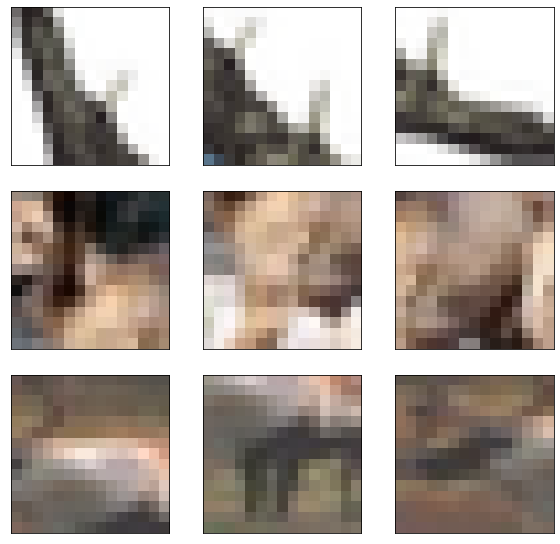

In [ ]:
sample_patches = patch_data[0:9].reshape(9, 3, 15, 15)
show_patches(sample_patches)

Show test sample:

tensor shape: (3, 32, 32)
min:          0.105882354
max:          1.0


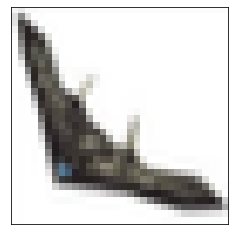

In [ ]:
show_sample(test_sample)

# Cluster Patch Data - 1st layer

In [ ]:
def show_center_patches(patches):
    print("tensor shape: " + str(patches.shape))
    
    fig = plt.figure(figsize=(8,8))
    for i in range(patches.shape[0]):
        plt.subplot(4,4,i+1)
        plt.tight_layout()
        patch = np.moveaxis(patches[i], 0, -1)
        plt.imshow(patch, cmap='gray', interpolation='none')
        plt.xticks([])
        plt.yticks([])

## Using PCA

Scale data:

In [ ]:
scaler = StandardScaler()
patch_data_scaled = scaler.fit_transform(patch_data)
sample_patch_data_scaled = scaler.fit_transform(sample_patch_data)

Reduce data to 2D using PCA:

In [ ]:
pca = PCA(n_components=2)
patch_data_2d_pca = pca.fit_transform(patch_data_scaled); patch_data_2d_pca.shape

(165450, 2)

Apply kMeans:

In [ ]:
#kmeans_pca = KMeans(n_clusters=16, random_state=0).fit(patch_data_2d_pca)

Get the closest patch for each cluster center:

In [ ]:
#closest_pca, _ = pairwise_distances_argmin_min(kmeans_pca.cluster_centers_, patch_data_2d_pca)

In [ ]:
#center_patches_pca = []
#
#for c in closest_pca:
#    temp_patch = patch_data[c].reshape(1, 3, 15, 15)
#    center_patches_pca.append(temp_patch)
#
#center_patches_pca = np.vstack(center_patches_pca)
#show_center_patches(center_patches_pca)

Save found patches:

In [ ]:
#center_patches_pca.shape

In [ ]:
#result_path_pca = base_url + "cifar10_patches_pca_kmeans_multilayer1.txt"
#with open(result_path_pca, "wb") as fp:
#    pickle.dump(center_patches_pca, fp)

Get the k closest patches for each cluster center:

In [ ]:
#k = 10

In [ ]:
#distances_pca = pairwise_distances(kmeans_pca.cluster_centers_, patch_data_2d_pca); distances_pca.shape

In [ ]:
#nearest_idx_pca = np.argsort(distances_pca, axis=1)[:,:k]; nearest_idx_pca[:,0]

Check if we really found the k closest clusters:

In [ ]:
#for i in range(kmeans_pca.cluster_centers_.shape[0]):
#    center_distances = distances_pca[i][nearest_idx_pca[i]]
#    farthest = max(center_distances)
#    nearer_points = distances_pca[i] < farthest
#    assert Counter(nearer_points)[True] == (k-1)

Average k closest samples for each cluster:

In [ ]:
#center_patches_avg_pca = []
#
#for c in range(nearest_idx_pca.shape[0]):
#    temp_patch = np.zeros((1,3,15,15))
#
#    for s in range(nearest_idx_pca.shape[1]):
#        temp_idx = nearest_idx_pca[c,s]
#        temp_patch = temp_patch + patch_data[temp_idx].reshape(1,3,15,15)
#
#    temp_patch = temp_patch / (nearest_idx_pca.shape[1])
#    center_patches_avg_pca.append(temp_patch)
#
#center_patches_avg_pca = np.vstack(center_patches_avg_pca)
#show_center_patches(center_patches_avg_pca)

Save found average patches:

In [ ]:
#center_patches_avg_pca.shape

In [ ]:
#result_path_avg_pca = base_url + "cifar10_patches_avg_pca_kmeans_multilayer1.txt"
#with open(result_path_avg_pca, "wb") as fp:
#    pickle.dump(center_patches_avg_pca, fp)

## Using UMAP

Reduce data to 2D using UMAP:

In [ ]:
reducer = umap.UMAP()
patch_data_2d_umap = reducer.fit_transform(sample_patch_data_scaled); patch_data_2d_umap.shape

(51334, 2)

Apply kMeans:

In [ ]:
#kmeans_umap = KMeans(n_clusters=16, random_state=0).fit(patch_data_2d_umap)

Get the closest patch for each cluster center:

In [ ]:
#closest_umap, _ = pairwise_distances_argmin_min(kmeans_umap.cluster_centers_, patch_data_2d_umap)

In [ ]:
#center_patches_umap = []
#
#for c in closest_umap:
#    temp_patch = patch_data[c].reshape(1,3,15,15)
#    center_patches_umap.append(temp_patch)
#
#center_patches_umap = np.vstack(center_patches_umap)
#show_center_patches(center_patches_umap)

Save found patches:

In [ ]:
#center_patches_umap.shape

In [ ]:
#result_path_umap = base_url + "cifar10_patches_umap_kmeans_multilayer1.txt"
#with open(result_path_umap, "wb") as fp:
#    pickle.dump(center_patches_umap, fp)

Get the k closest patches for each cluster center:

In [ ]:
#k = 5

In [ ]:
#distances_umap = pairwise_distances(kmeans_umap.cluster_centers_, patch_data_2d_umap); distances_umap.shape

In [ ]:
#nearest_idx_umap = np.argsort(distances_umap, axis=1)[:,:k]; nearest_idx_umap[:,0]

Check if we really found the k closest clusters:

In [ ]:
#for i in range(kmeans_umap.cluster_centers_.shape[0]):
#    center_distances = distances_umap[i][nearest_idx_umap[i]]
#    farthest = max(center_distances)
#    nearer_points = distances_umap[i] < farthest
#    assert Counter(nearer_points)[True] == (k-1)

Average k closest samples for each cluster:

In [ ]:
#center_patches_avg_umap = []
#
#for c in range(nearest_idx_umap.shape[0]):
#    temp_patch = np.zeros((1,3,15,15))
#
#    for s in range(nearest_idx_umap.shape[1]):
#        temp_idx = nearest_idx_umap[c,s]
#        temp_patch = temp_patch + patch_data[temp_idx].reshape(1,3,15,15)
#
#    temp_patch = temp_patch / (nearest_idx_umap.shape[1])
#    center_patches_avg_umap.append(temp_patch)
#
#center_patches_avg_umap = np.vstack(center_patches_avg_umap)
#show_center_patches(center_patches_avg_umap)

Save found average patches:

In [ ]:
#center_patches_avg_umap.shape

In [ ]:
#result_path_avg_umap = base_url + "cifar10_patches_avg_umap_kmeans_multilayer1.txt"
#with open(result_path_avg_umap, "wb") as fp:
#    pickle.dump(center_patches_avg_umap, fp)

Get the k closest patches for each cluster center:

In [ ]:
#k = 10

In [ ]:
#distances_umap = pairwise_distances(kmeans_umap.cluster_centers_, patch_data_2d_umap); distances_umap.shape

In [ ]:
#nearest_idx_umap = np.argsort(distances_umap, axis=1)[:,:k]; nearest_idx_umap[:,0]

Check if we really found the k closest clusters:

In [ ]:
#for i in range(kmeans_umap.cluster_centers_.shape[0]):
#    center_distances = distances_umap[i][nearest_idx_umap[i]]
#    farthest = max(center_distances)
#    nearer_points = distances_umap[i] < farthest
#    assert Counter(nearer_points)[True] == (k-1)

Average k closest samples for each cluster:

In [ ]:
#center_patches_avg_umap = []
#
#for c in range(nearest_idx_umap.shape[0]):
#    temp_patch = np.zeros((1,3,15,15))
#
#    for s in range(nearest_idx_umap.shape[1]):
#        temp_idx = nearest_idx_umap[c,s]
#        temp_patch = temp_patch + patch_data[temp_idx].reshape(1,3,15,15)
#
#    temp_patch = temp_patch / (nearest_idx_umap.shape[1])
#    center_patches_avg_umap.append(temp_patch)
#
#center_patches_avg_umap = np.vstack(center_patches_avg_umap)
#show_center_patches(center_patches_avg_umap)

Save found average patches:

In [ ]:
#center_patches_avg_umap.shape

In [ ]:
#result_path_avg_umap = base_url + "mnist_patches_avg_more_umap_kmeans_multilayer1.txt"
#with open(result_path_avg_umap, "wb") as fp:
#    pickle.dump(center_patches_avg_umap, fp)

## Using t-SNE

Reduce data to 2D using t-SNE:

In [ ]:
#patch_data_2d_tsne = TSNE(n_components=2).fit_transform(sample_patch_data_scaled); patch_data_2d_tsne.shape

Apply kMeans:

In [ ]:
#kmeans_tsne = KMeans(n_clusters=16, random_state=0).fit(patch_data_2d_tsne)

Get the closest patch for each cluster center:

In [ ]:
#closest_tsne, _ = pairwise_distances_argmin_min(kmeans_tsne.cluster_centers_, patch_data_2d_tsne)

In [ ]:
#center_patches_tsne = []
#
#for c in closest_tsne:
#    temp_patch = patch_data[c].reshape(1,3,15,15)
#    center_patches_tsne.append(temp_patch)
#
#center_patches_tsne = np.vstack(center_patches_tsne)
#show_center_patches(center_patches_tsne)

Save found patches:

In [ ]:
#center_patches_tsne.shape

In [ ]:
#result_path_tsne = base_url + "cifar10_patches_tsne_kmeans.txt"
#with open(result_path_tsne, "wb") as fp:
#    pickle.dump(center_patches_tsne, fp)

# Cluster Patch Data - 2nd layer

In [ ]:
#def show_center_patches(patches):
#    print("tensor shape: " + str(patches.shape))
#    
#    fig = plt.figure(figsize=(8,8))
#    for i in range(patches.shape[0]):
#        plt.subplot(4,4,i+1)
#        plt.tight_layout()
#        patch = np.moveaxis(patches[i], 0, -1)
#        plt.imshow(patch, cmap='gray', interpolation='none')
#        plt.xticks([])
#        plt.yticks([])

## Using PCA

Scale data:

In [ ]:
#scaler = StandardScaler()
#patch_data_scaled = scaler.fit_transform(patch_data)
#sample_patch_data_scaled = scaler.fit_transform(sample_patch_data)

Reduce data to 2D using PCA:

In [ ]:
#pca = PCA(n_components=2)
#patch_data_2d_pca = pca.fit_transform(patch_data_scaled); patch_data_2d_pca.shape

Apply kMeans:

In [ ]:
#kmeans_pca = KMeans(n_clusters=86, random_state=0).fit(patch_data_2d_pca)

Get the closest patch for each cluster center:

In [ ]:
#closest_pca, _ = pairwise_distances_argmin_min(kmeans_pca.cluster_centers_, patch_data_2d_pca)

In [ ]:
#center_patches_pca = []
#
#for c in closest_pca:
#    temp_patch = patch_data[c].reshape(1, 3, 15, 15)
#    center_patches_pca.append(temp_patch)
#
#center_patches_pca = np.vstack(center_patches_pca)
#show_center_patches(center_patches_pca[:16])

Save found patches:

In [ ]:
#center_patches_pca.shape

In [ ]:
#result_path_pca = base_url + "cifar10_patches_pca_kmeans_multilayer2.txt"
#with open(result_path_pca, "wb") as fp:
#    pickle.dump(center_patches_pca, fp)

Get the k closest patches for each cluster center:

In [ ]:
#k = 10

In [ ]:
#distances_pca = pairwise_distances(kmeans_pca.cluster_centers_, patch_data_2d_pca); distances_pca.shape

In [ ]:
#nearest_idx_pca = np.argsort(distances_pca, axis=1)[:,:k]; nearest_idx_pca[:,0]

Check if we really found the k closest clusters:

In [ ]:
#for i in range(kmeans_pca.cluster_centers_.shape[0]):
#    center_distances = distances_pca[i][nearest_idx_pca[i]]
#    farthest = max(center_distances)
#    nearer_points = distances_pca[i] < farthest
#    assert Counter(nearer_points)[True] == (k-1)

Average k closest samples for each cluster:

In [ ]:
#center_patches_avg_pca = []
#
#for c in range(nearest_idx_pca.shape[0]):
#    temp_patch = np.zeros((1,3,15,15))
#
#    for s in range(nearest_idx_pca.shape[1]):
#        temp_idx = nearest_idx_pca[c,s]
#        temp_patch = temp_patch + patch_data[temp_idx].reshape(1,3,15,15)
#
#    temp_patch = temp_patch / (nearest_idx_pca.shape[1])
#    center_patches_avg_pca.append(temp_patch)
#
#center_patches_avg_pca = np.vstack(center_patches_avg_pca)
#show_center_patches(center_patches_avg_pca[:16])

Save found average patches:

In [ ]:
#center_patches_avg_pca.shape

In [ ]:
#result_path_avg_pca = base_url + "cifar10_patches_avg_pca_kmeans_multilayer2.txt"
#with open(result_path_avg_pca, "wb") as fp:
#    pickle.dump(center_patches_avg_pca, fp)

## Using UMAP

Reduce data to 2D using UMAP:

In [ ]:
#reducer = umap.UMAP()
#patch_data_2d_umap = reducer.fit_transform(sample_patch_data_scaled); patch_data_2d_umap.shape

Apply kMeans:

In [ ]:
#kmeans_umap = KMeans(n_clusters=86, random_state=0).fit(patch_data_2d_umap)

Get the closest patch for each cluster center:

In [ ]:
#closest_umap, _ = pairwise_distances_argmin_min(kmeans_umap.cluster_centers_, patch_data_2d_umap)

In [ ]:
#center_patches_umap = []
#
#for c in closest_umap:
#    temp_patch = patch_data[c].reshape(1,3,15,15)
#    center_patches_umap.append(temp_patch)
#
#center_patches_umap = np.vstack(center_patches_umap)
#show_center_patches(center_patches_umap[:16])

Save found patches:

In [ ]:
#center_patches_umap.shape

In [ ]:
#result_path_umap = base_url + "cifar10_patches_umap_kmeans_multilayer2.txt"
#with open(result_path_umap, "wb") as fp:
#    pickle.dump(center_patches_umap, fp)

Get the k closest patches for each cluster center:

In [ ]:
#k = 5

In [ ]:
#distances_umap = pairwise_distances(kmeans_umap.cluster_centers_, patch_data_2d_umap); distances_umap.shape

In [ ]:
#nearest_idx_umap = np.argsort(distances_umap, axis=1)[:,:k]; nearest_idx_umap[:,0]

Check if we really found the k closest clusters:

In [ ]:
#for i in range(kmeans_umap.cluster_centers_.shape[0]):
#    center_distances = distances_umap[i][nearest_idx_umap[i]]
#    farthest = max(center_distances)
#    nearer_points = distances_umap[i] < farthest
#    assert Counter(nearer_points)[True] == (k-1)

Average k closest samples for each cluster:

In [ ]:
#center_patches_avg_umap = []
#
#for c in range(nearest_idx_umap.shape[0]):
#    temp_patch = np.zeros((1,3,15,15))
#
#    for s in range(nearest_idx_umap.shape[1]):
#        temp_idx = nearest_idx_umap[c,s]
#        temp_patch = temp_patch + patch_data[temp_idx].reshape(1,3,15,15)
#
#    temp_patch = temp_patch / (nearest_idx_umap.shape[1])
#    center_patches_avg_umap.append(temp_patch)
#
#center_patches_avg_umap = np.vstack(center_patches_avg_umap)
#show_center_patches(center_patches_avg_umap[:16])

Save found average patches:

In [ ]:
#center_patches_avg_umap.shape

In [ ]:
#result_path_avg_umap = base_url + "cifar10_patches_avg_umap_kmeans_multilayer2.txt"
#with open(result_path_avg_umap, "wb") as fp:
#    pickle.dump(center_patches_avg_umap, fp)

Get the k closest patches for each cluster center:

In [ ]:
#k = 10

In [ ]:
#distances_umap = pairwise_distances(kmeans_umap.cluster_centers_, patch_data_2d_umap); distances_umap.shape

In [ ]:
#nearest_idx_umap = np.argsort(distances_umap, axis=1)[:,:k]; nearest_idx_umap[:,0]

Check if we really found the k closest clusters:

In [ ]:
#for i in range(kmeans_umap.cluster_centers_.shape[0]):
#    center_distances = distances_umap[i][nearest_idx_umap[i]]
#    farthest = max(center_distances)
#    nearer_points = distances_umap[i] < farthest
#    assert Counter(nearer_points)[True] == (k-1)

Average k closest samples for each cluster:

In [ ]:
#center_patches_avg_umap = []
#
#for c in range(nearest_idx_umap.shape[0]):
#    temp_patch = np.zeros((1,3,15,15))
#
#    for s in range(nearest_idx_umap.shape[1]):
#        temp_idx = nearest_idx_umap[c,s]
#        temp_patch = temp_patch + patch_data[temp_idx].reshape(1,3,15,15)
#
#    temp_patch = temp_patch / (nearest_idx_umap.shape[1])
#    center_patches_avg_umap.append(temp_patch)
#
#center_patches_avg_umap = np.vstack(center_patches_avg_umap)
#show_center_patches(center_patches_avg_umap[:16])

Save found average patches:

In [ ]:
#center_patches_avg_umap.shape

In [ ]:
#result_path_avg_umap = base_url + "mnist_patches_avg_more_umap_kmeans_multilayer2.txt"
#with open(result_path_avg_umap, "wb") as fp:
#    pickle.dump(center_patches_avg_umap, fp)

# Cluster Patch Data - 3rd layer

In [ ]:
#def show_center_patches(patches):
#    print("tensor shape: " + str(patches.shape))
#    
#    fig = plt.figure(figsize=(8,8))
#    for i in range(patches.shape[0]):
#        plt.subplot(4,4,i+1)
#        plt.tight_layout()
#        patch = np.moveaxis(patches[i], 0, -1)
#        plt.imshow(patch, cmap='gray', interpolation='none')
#        plt.xticks([])
#        plt.yticks([])

## Using PCA

Scale data:

In [ ]:
#scaler = StandardScaler()
#patch_data_scaled = scaler.fit_transform(patch_data)
#sample_patch_data_scaled = scaler.fit_transform(sample_patch_data)

Reduce data to 2D using PCA:

In [ ]:
#pca = PCA(n_components=2)
#patch_data_2d_pca = pca.fit_transform(patch_data_scaled); patch_data_2d_pca.shape

Apply kMeans:

In [ ]:
#kmeans_pca = KMeans(n_clusters=342, random_state=0).fit(patch_data_2d_pca)

Get the closest patch for each cluster center:

In [ ]:
#closest_pca, _ = pairwise_distances_argmin_min(kmeans_pca.cluster_centers_, patch_data_2d_pca)

In [ ]:
#center_patches_pca = []
#
#for c in closest_pca:
#    temp_patch = patch_data[c].reshape(1, 3, 15, 15)
#    center_patches_pca.append(temp_patch)
#
#center_patches_pca = np.vstack(center_patches_pca)
#show_center_patches(center_patches_pca[:16])

Save found patches:

In [ ]:
#center_patches_pca.shape

In [ ]:
#result_path_pca = base_url + "cifar10_patches_pca_kmeans_multilayer3.txt"
#with open(result_path_pca, "wb") as fp:
#    pickle.dump(center_patches_pca, fp)

Get the k closest patches for each cluster center:

In [ ]:
#k = 10

In [ ]:
#distances_pca = pairwise_distances(kmeans_pca.cluster_centers_, patch_data_2d_pca); distances_pca.shape

In [ ]:
#nearest_idx_pca = np.argsort(distances_pca, axis=1)[:,:k]; nearest_idx_pca[:,0]

Check if we really found the k closest clusters:

In [ ]:
#for i in range(kmeans_pca.cluster_centers_.shape[0]):
#    center_distances = distances_pca[i][nearest_idx_pca[i]]
#    farthest = max(center_distances)
#    nearer_points = distances_pca[i] < farthest
#    assert Counter(nearer_points)[True] == (k-1)

Average k closest samples for each cluster:

In [ ]:
#center_patches_avg_pca = []
#
#for c in range(nearest_idx_pca.shape[0]):
#    temp_patch = np.zeros((1,3,15,15))
#
#    for s in range(nearest_idx_pca.shape[1]):
#        temp_idx = nearest_idx_pca[c,s]
#        temp_patch = temp_patch + patch_data[temp_idx].reshape(1,3,15,15)
#
#    temp_patch = temp_patch / (nearest_idx_pca.shape[1])
#    center_patches_avg_pca.append(temp_patch)
#
#center_patches_avg_pca = np.vstack(center_patches_avg_pca)
#show_center_patches(center_patches_avg_pca[:16])

Save found average patches:

In [ ]:
#center_patches_avg_pca.shape

In [ ]:
#result_path_avg_pca = base_url + "cifar10_patches_avg_pca_kmeans_multilayer3.txt"
#with open(result_path_avg_pca, "wb") as fp:
#    pickle.dump(center_patches_avg_pca, fp)

## Using UMAP

Reduce data to 2D using UMAP:

In [ ]:
#reducer = umap.UMAP()
#patch_data_2d_umap = reducer.fit_transform(sample_patch_data_scaled); patch_data_2d_umap.shape

Apply kMeans:

In [ ]:
#kmeans_umap = KMeans(n_clusters=342, random_state=0).fit(patch_data_2d_umap)

Get the closest patch for each cluster center:

In [ ]:
#closest_umap, _ = pairwise_distances_argmin_min(kmeans_umap.cluster_centers_, patch_data_2d_umap)

In [ ]:
#center_patches_umap = []
#
#for c in closest_umap:
#    temp_patch = patch_data[c].reshape(1,3,15,15)
#    center_patches_umap.append(temp_patch)
#
#center_patches_umap = np.vstack(center_patches_umap)
#show_center_patches(center_patches_umap[:16])

Save found patches:

In [ ]:
#center_patches_umap.shape

In [ ]:
#result_path_umap = base_url + "cifar10_patches_umap_kmeans_multilayer3.txt"
#with open(result_path_umap, "wb") as fp:
#    pickle.dump(center_patches_umap, fp)

Get the k closest patches for each cluster center:

In [ ]:
#k = 5

In [ ]:
#distances_umap = pairwise_distances(kmeans_umap.cluster_centers_, patch_data_2d_umap); distances_umap.shape

In [ ]:
#nearest_idx_umap = np.argsort(distances_umap, axis=1)[:,:k]; nearest_idx_umap[:,0]

Check if we really found the k closest clusters:

In [ ]:
#for i in range(kmeans_umap.cluster_centers_.shape[0]):
#    center_distances = distances_umap[i][nearest_idx_umap[i]]
#    farthest = max(center_distances)
#    nearer_points = distances_umap[i] < farthest
#    assert Counter(nearer_points)[True] == (k-1)

Average k closest samples for each cluster:

In [ ]:
#center_patches_avg_umap = []
#
#for c in range(nearest_idx_umap.shape[0]):
#    temp_patch = np.zeros((1,3,15,15))
#
#    for s in range(nearest_idx_umap.shape[1]):
#        temp_idx = nearest_idx_umap[c,s]
#        temp_patch = temp_patch + patch_data[temp_idx].reshape(1,3,15,15)
#
#    temp_patch = temp_patch / (nearest_idx_umap.shape[1])
#    center_patches_avg_umap.append(temp_patch)
#
#center_patches_avg_umap = np.vstack(center_patches_avg_umap)
#show_center_patches(center_patches_avg_umap[:16])

Save found average patches:

In [ ]:
#center_patches_avg_umap.shape

In [ ]:
#result_path_avg_umap = base_url + "cifar10_patches_avg_umap_kmeans_multilayer3.txt"
#with open(result_path_avg_umap, "wb") as fp:
#    pickle.dump(center_patches_avg_umap, fp)

Get the k closest patches for each cluster center:

In [ ]:
#k = 10

In [ ]:
#distances_umap = pairwise_distances(kmeans_umap.cluster_centers_, patch_data_2d_umap); distances_umap.shape

In [ ]:
#nearest_idx_umap = np.argsort(distances_umap, axis=1)[:,:k]; nearest_idx_umap[:,0]

Check if we really found the k closest clusters:

In [ ]:
#for i in range(kmeans_umap.cluster_centers_.shape[0]):
#    center_distances = distances_umap[i][nearest_idx_umap[i]]
#    farthest = max(center_distances)
#    nearer_points = distances_umap[i] < farthest
#    assert Counter(nearer_points)[True] == (k-1)

Average k closest samples for each cluster:

In [ ]:
#center_patches_avg_umap = []
#
#for c in range(nearest_idx_umap.shape[0]):
#    temp_patch = np.zeros((1,3,15,15))
#
#    for s in range(nearest_idx_umap.shape[1]):
#        temp_idx = nearest_idx_umap[c,s]
#        temp_patch = temp_patch + patch_data[temp_idx].reshape(1,3,15,15)
#
#    temp_patch = temp_patch / (nearest_idx_umap.shape[1])
#    center_patches_avg_umap.append(temp_patch)
#
#center_patches_avg_umap = np.vstack(center_patches_avg_umap)
#show_center_patches(center_patches_avg_umap[:16])

Save found average patches:

In [ ]:
#center_patches_avg_umap.shape

In [ ]:
#result_path_avg_umap = base_url + "mnist_patches_avg_more_umap_kmeans_multilayer3.txt"
#with open(result_path_avg_umap, "wb") as fp:
#    pickle.dump(center_patches_avg_umap, fp)

# Cluster Patch Data - 4nd layer

In [ ]:
#def show_center_patches(patches):
#    print("tensor shape: " + str(patches.shape))
#    
#    fig = plt.figure(figsize=(8,8))
#    for i in range(patches.shape[0]):
#        plt.subplot(4,4,i+1)
#        plt.tight_layout()
#        patch = np.moveaxis(patches[i], 0, -1)
#        plt.imshow(patch, cmap='gray', interpolation='none')
#        plt.xticks([])
#        plt.yticks([])

## Using PCA

Scale data:

In [ ]:
#scaler = StandardScaler()
#patch_data_scaled = scaler.fit_transform(patch_data)
#sample_patch_data_scaled = scaler.fit_transform(sample_patch_data)

Reduce data to 2D using PCA:

In [ ]:
#pca = PCA(n_components=2)
#patch_data_2d_pca = pca.fit_transform(patch_data_scaled); patch_data_2d_pca.shape

Apply kMeans:

In [ ]:
kmeans_pca = KMeans(n_clusters=1366, random_state=0).fit(patch_data_2d_pca)

Get the closest patch for each cluster center:

In [ ]:
closest_pca, _ = pairwise_distances_argmin_min(kmeans_pca.cluster_centers_, patch_data_2d_pca)

tensor shape: (16, 3, 15, 15)


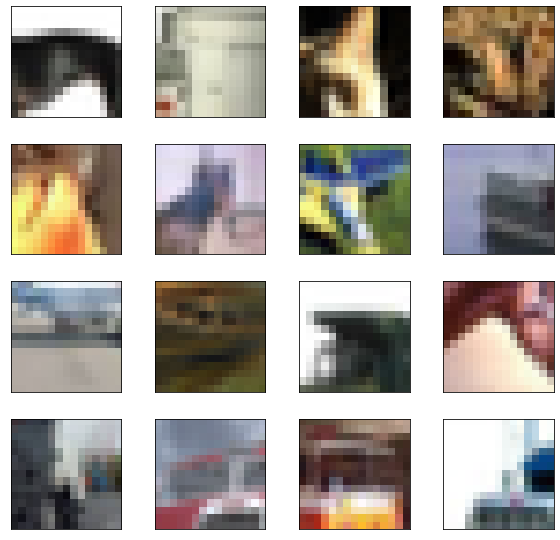

In [ ]:
center_patches_pca = []

for c in closest_pca:
    temp_patch = patch_data[c].reshape(1, 3, 15, 15)
    center_patches_pca.append(temp_patch)

center_patches_pca = np.vstack(center_patches_pca)
show_center_patches(center_patches_pca[:16])

Save found patches:

In [ ]:
center_patches_pca.shape

(1366, 3, 15, 15)

In [ ]:
result_path_pca = base_url + "cifar10_patches_pca_kmeans_multilayer4.txt"
with open(result_path_pca, "wb") as fp:
    pickle.dump(center_patches_pca, fp)

Get the k closest patches for each cluster center:

In [ ]:
k = 10

In [ ]:
distances_pca = pairwise_distances(kmeans_pca.cluster_centers_, patch_data_2d_pca); distances_pca.shape

(1366, 165450)

In [ ]:
nearest_idx_pca = np.argsort(distances_pca, axis=1)[:,:k]; nearest_idx_pca[:,0]

array([ 31169, 144951, 137299, ...,  92661,   4139,   9126])

Check if we really found the k closest clusters:

In [ ]:
for i in range(kmeans_pca.cluster_centers_.shape[0]):
    center_distances = distances_pca[i][nearest_idx_pca[i]]
    farthest = max(center_distances)
    nearer_points = distances_pca[i] < farthest
    assert Counter(nearer_points)[True] == (k-1)

Average k closest samples for each cluster:

tensor shape: (16, 3, 15, 15)


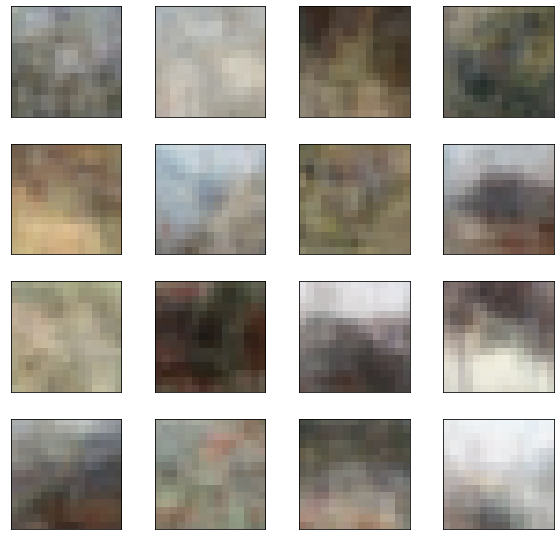

In [ ]:
center_patches_avg_pca = []

for c in range(nearest_idx_pca.shape[0]):
    temp_patch = np.zeros((1,3,15,15))

    for s in range(nearest_idx_pca.shape[1]):
        temp_idx = nearest_idx_pca[c,s]
        temp_patch = temp_patch + patch_data[temp_idx].reshape(1,3,15,15)

    temp_patch = temp_patch / (nearest_idx_pca.shape[1])
    center_patches_avg_pca.append(temp_patch)

center_patches_avg_pca = np.vstack(center_patches_avg_pca)
show_center_patches(center_patches_avg_pca[:16])

Save found average patches:

In [ ]:
center_patches_avg_pca.shape

(1366, 3, 15, 15)

In [ ]:
result_path_avg_pca = base_url + "cifar10_patches_avg_pca_kmeans_multilayer4.txt"
with open(result_path_avg_pca, "wb") as fp:
    pickle.dump(center_patches_avg_pca, fp)

## Using UMAP

Reduce data to 2D using UMAP:

In [ ]:
#reducer = umap.UMAP()
#patch_data_2d_umap = reducer.fit_transform(sample_patch_data_scaled); patch_data_2d_umap.shape

Apply kMeans:

In [ ]:
kmeans_umap = KMeans(n_clusters=1366, random_state=0).fit(patch_data_2d_umap)

Get the closest patch for each cluster center:

In [ ]:
closest_umap, _ = pairwise_distances_argmin_min(kmeans_umap.cluster_centers_, patch_data_2d_umap)

tensor shape: (16, 3, 15, 15)


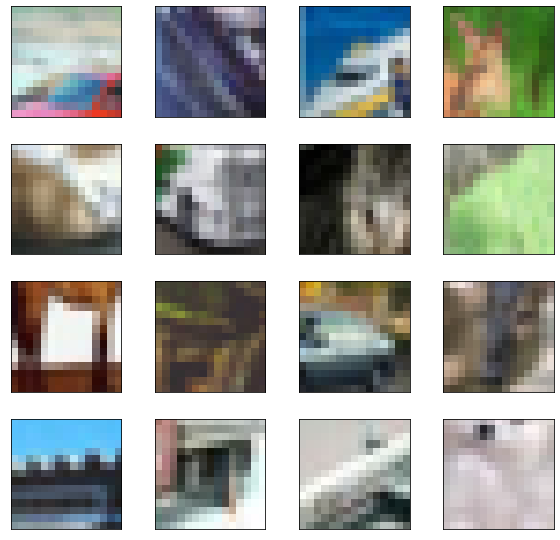

In [ ]:
center_patches_umap = []

for c in closest_umap:
    temp_patch = patch_data[c].reshape(1,3,15,15)
    center_patches_umap.append(temp_patch)

center_patches_umap = np.vstack(center_patches_umap)
show_center_patches(center_patches_umap[:16])

Save found patches:

In [ ]:
center_patches_umap.shape

(1366, 3, 15, 15)

In [ ]:
result_path_umap = base_url + "cifar10_patches_umap_kmeans_multilayer4.txt"
with open(result_path_umap, "wb") as fp:
    pickle.dump(center_patches_umap, fp)

Get the k closest patches for each cluster center:

In [ ]:
k = 5

In [ ]:
distances_umap = pairwise_distances(kmeans_umap.cluster_centers_, patch_data_2d_umap); distances_umap.shape

(1366, 51334)

In [ ]:
nearest_idx_umap = np.argsort(distances_umap, axis=1)[:,:k]; nearest_idx_umap[:,0]

array([ 3877, 32839, 30482, ..., 20829,  6192, 43722])

Check if we really found the k closest clusters:

In [ ]:
for i in range(kmeans_umap.cluster_centers_.shape[0]):
    center_distances = distances_umap[i][nearest_idx_umap[i]]
    farthest = max(center_distances)
    nearer_points = distances_umap[i] < farthest
    assert Counter(nearer_points)[True] == (k-1)

Average k closest samples for each cluster:

tensor shape: (16, 3, 15, 15)


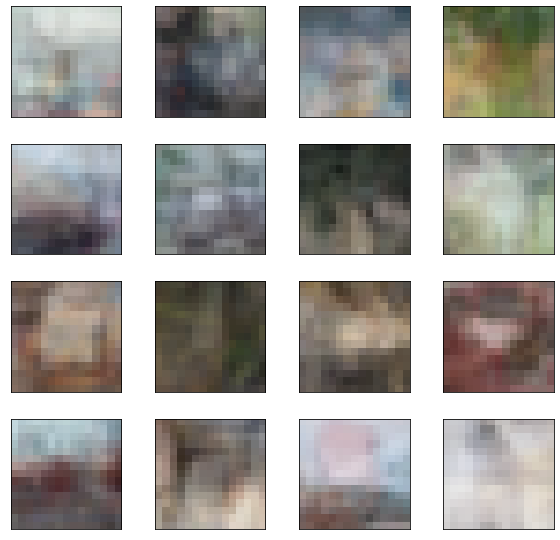

In [ ]:
center_patches_avg_umap = []

for c in range(nearest_idx_umap.shape[0]):
    temp_patch = np.zeros((1,3,15,15))

    for s in range(nearest_idx_umap.shape[1]):
        temp_idx = nearest_idx_umap[c,s]
        temp_patch = temp_patch + patch_data[temp_idx].reshape(1,3,15,15)

    temp_patch = temp_patch / (nearest_idx_umap.shape[1])
    center_patches_avg_umap.append(temp_patch)

center_patches_avg_umap = np.vstack(center_patches_avg_umap)
show_center_patches(center_patches_avg_umap[:16])

Save found average patches:

In [ ]:
center_patches_avg_umap.shape

(1366, 3, 15, 15)

In [ ]:
result_path_avg_umap = base_url + "cifar10_patches_avg_umap_kmeans_multilayer4.txt"
with open(result_path_avg_umap, "wb") as fp:
    pickle.dump(center_patches_avg_umap, fp)

Get the k closest patches for each cluster center:

In [ ]:
k = 10

In [ ]:
distances_umap = pairwise_distances(kmeans_umap.cluster_centers_, patch_data_2d_umap); distances_umap.shape

(1366, 51334)

In [ ]:
nearest_idx_umap = np.argsort(distances_umap, axis=1)[:,:k]; nearest_idx_umap[:,0]

array([ 3877, 32839, 30482, ..., 20829,  6192, 43722])

Check if we really found the k closest clusters:

In [ ]:
for i in range(kmeans_umap.cluster_centers_.shape[0]):
    center_distances = distances_umap[i][nearest_idx_umap[i]]
    farthest = max(center_distances)
    nearer_points = distances_umap[i] < farthest
    assert Counter(nearer_points)[True] == (k-1)

Average k closest samples for each cluster:

tensor shape: (16, 3, 15, 15)


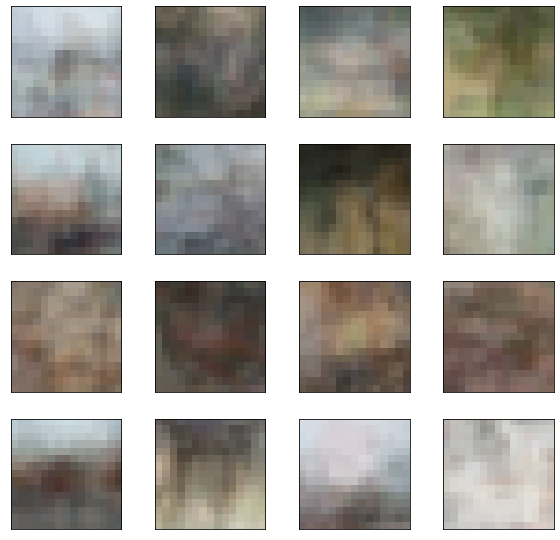

In [ ]:
center_patches_avg_umap = []

for c in range(nearest_idx_umap.shape[0]):
    temp_patch = np.zeros((1,3,15,15))

    for s in range(nearest_idx_umap.shape[1]):
        temp_idx = nearest_idx_umap[c,s]
        temp_patch = temp_patch + patch_data[temp_idx].reshape(1,3,15,15)

    temp_patch = temp_patch / (nearest_idx_umap.shape[1])
    center_patches_avg_umap.append(temp_patch)

center_patches_avg_umap = np.vstack(center_patches_avg_umap)
show_center_patches(center_patches_avg_umap[:16])

Save found average patches:

In [ ]:
center_patches_avg_umap.shape

(1366, 3, 15, 15)

In [ ]:
result_path_avg_umap = base_url + "mnist_patches_avg_more_umap_kmeans_multilayer4.txt"
with open(result_path_avg_umap, "wb") as fp:
    pickle.dump(center_patches_avg_umap, fp)